# Stereo template matching/block matching


In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data

plt.gray()

<Figure size 640x480 with 0 Axes>

Start by loading a set of corresponding left and right image. We also resize the images since the computations we expect to do can take a long time to process. Resizing is optional, but recommended atleast until you have verified your computer is capable of doing the computations within reasonable time.

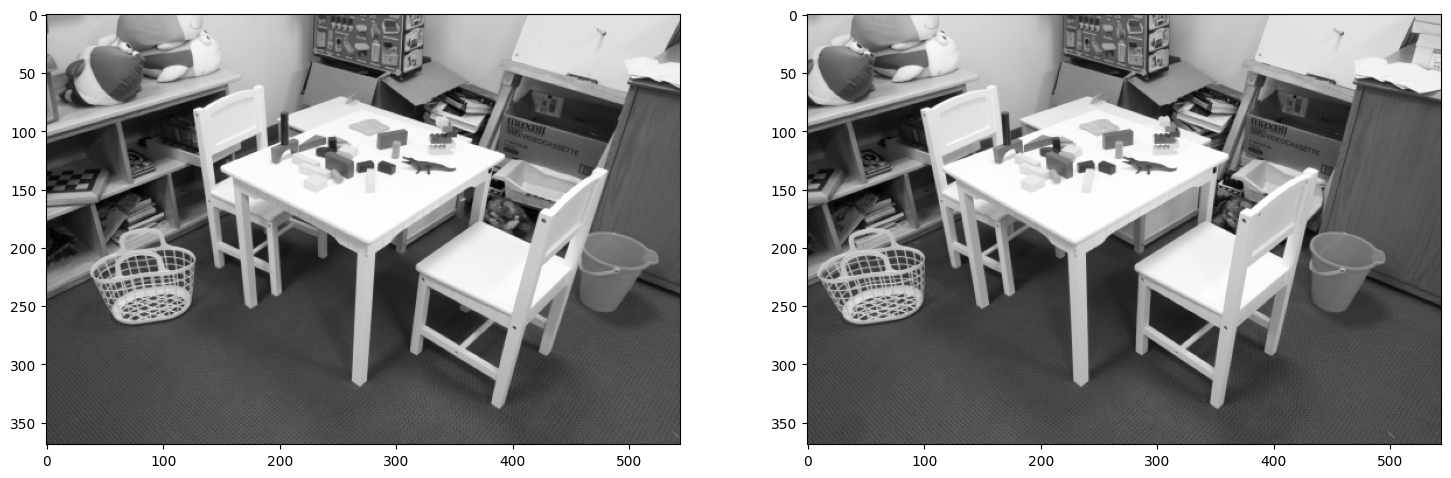

In [7]:
# load the images
img_left = cv2.imread("playtable_left.png")
img_right = cv2.imread("playtable_right.png")

# rescale images (can be left out)
img_size = (int(img_left.shape[1]/5), int(img_left.shape[0]/5))
img_left = cv2.resize(img_left, img_size, interpolation=cv2.INTER_AREA)
img_right = cv2.resize(img_right, img_size, interpolation=cv2.INTER_AREA)

# convert images to grayscale for template matching
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left)
ax_right.imshow(gray_right)

Next step is to create a disparity map based on the two stereo images. This is done using the same procedure as we did with exercise 1, except now we look for blocks of pixel from the left image in the right image, or vice versa.

## Exercise 2.1
You will have to play with the below parameters until you find a good solution that gives a representative 3D projection. Reflect/search on what those parameters actually mean and how they influence the outcome.

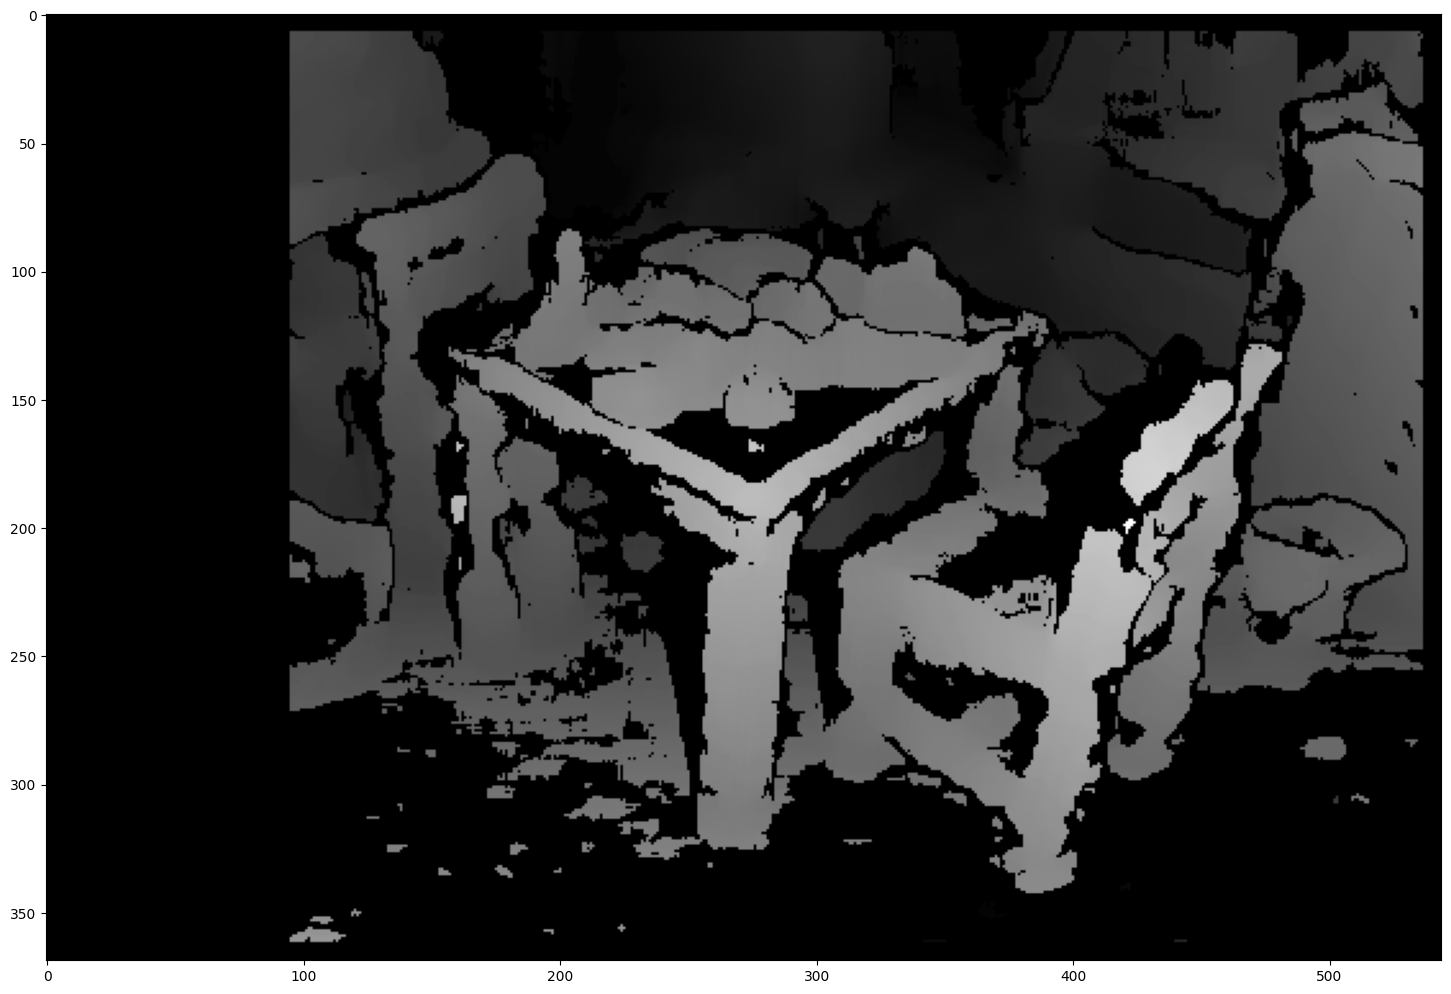

In [8]:
# Set parameters for the StereoBM algorithm
# StereoBM (Block Matching) is an algorithm to compute the disparity map
# The disparity map encodes the depth of objects in the scene

# Set parameters for the StereoBM algorithm
min_disp = 9  # Minimum disparity (how much the images can shift). Higher values focus on distant objects.
num_disp = 5 * 16  # Total disparity range. Must be divisible by 16. Higher values = larger depth range, but slower.
block_size = 15  # Size of blocks for matching. Larger values = smoother but less detailed. Smaller = more detail, more noise.

# Create the StereoBM object
stereo = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)

# Set additional fine-tuning parameters
stereo.setMinDisparity(min_disp)  # Sets the minimum disparity
stereo.setDisp12MaxDiff(100)  # Max difference between left and right disparities. Lower = more accurate, higher = looser.
stereo.setUniquenessRatio(20)  # How unique a match must be. Higher = stricter matching, lower = more noise.
stereo.setSpeckleRange(3)  # Max disparity variation in speckles (noise). Lower = more aggressive noise removal.
stereo.setSpeckleWindowSize(3)  # Size of noisy regions to be removed. Higher = keep more valid data but may retain noise.
disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

plt.figure(figsize=(18,18))
plt.imshow(disp)

## Exercise 2.2
Once you have a disparity map without too much noise, you can use the below to export you disparity map to a .ply file that you can load and display in a 3D visualization software (e.g. [Meshlab](https://www.meshlab.net/#description)).

**Hint:** To open meshlab type `meshlab` in a terminal. 
To vizualize the point cloud, drag the generated `out.ply` into the meshlab scene or click `File` > `Import Mesh` and navigate to where our source-code is located and open `out.ply`. 

In [9]:
def export_pointcloud(disparity_map, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''

    def write_ply(fn, verts, colors):
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

    h, w = disparity_map.shape[:2]
    f = .8 * w  # guess for focal length. If you 3D reconstruction looks skewed in the viewing direction, try adjusting this parameter.
    Q = np.float32([[1, 0, 0, -0.5 * w],
                    [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
                    [0, 0, 0, -f],  # so that y-axis looks up
                    [0, 0, 1, 0]])
    points = cv2.reprojectImageTo3D(disparity_map, Q)
    
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]
    out_fn = 'out.ply'
    write_ply('out.ply', out_points, out_colors)
    print(f'{out_fn} saved')

export_pointcloud(disparity_map=disp, colors=img_left)

out.ply saved


## Exercise 2.3

Create a disparity map of the imageset `storage` and display it in meshlab.